# Problem Set 5, due March 8 at 11:59am, mid-day, noon.

Name: Shuyang Wu

Section: C

Date: 3/6/2017

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [93]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's likely [Oscar winner](http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [94]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]
print(reviews.head(10))
#print(movies.head(10))

               critic  fresh    imdb  \
0         Derek Adams  fresh  114709   
1     Richard Corliss  fresh  114709   
2         David Ansen  fresh  114709   
3       Leonard Klady  fresh  114709   
4  Jonathan Rosenbaum  fresh  114709   
5       Michael Booth  fresh  114709   
6        Geoff Andrew  fresh  114709   
7        Janet Maslin  fresh  114709   
8       Kenneth Turan  fresh  114709   
9         Roger Ebert  fresh  114709   

                                                link        publication  \
0  http://www.timeout.com/film/reviews/87745/toy-...           Time Out   
1  http://www.time.com/time/magazine/article/0,91...      TIME Magazine   
2                  http://www.newsweek.com/id/104199           Newsweek   
3  http://www.variety.com/review/VE1117941294.htm...            Variety   
4  http://onfilm.chicagoreader.com/movies/capsule...     Chicago Reader   
5        http://www.denverpost.com/movies/ci_5786068        Denver Post   
6  http://www.timeout.com/film/rev

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [95]:
# enter your code below
print("Number of reviews: %i" % len(reviews))
print("Number of unique reviewers (critics): %i" % len(reviews.critic.unique()))
print("Number of unique movies in the reviews dataset: %i" % len(reviews.title.unique()))
print("Number of unique movies in the movies dataset: %i" % len(movies.title.unique()))
print("Number of different publications in the reviews dataset: %i" % len(reviews.publication.unique()))

Number of reviews: 13419
Number of unique reviewers (critics): 541
Number of unique movies in the reviews dataset: 1720
Number of unique movies in the movies dataset: 9405
Number of different publications in the reviews dataset: 64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

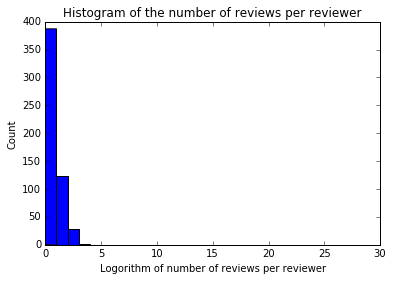

In [96]:
# enter your code here
import math
fig = reviews.groupby(['critic']).quote.count().apply(lambda g: math.log10(g)).plot(kind = 'hist', bins = 30, range=[0, 30])
fig.set_xlabel('Logorithm of number of reviews per reviewer')
fig.set_ylabel('Count')
fig.set_title('Histogram of the number of reviews per reviewer')

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [97]:
# enter your code here
name = pd.DataFrame(reviews.groupby(['critic']).quote.count().sort_values(ascending = False).head(30))
publications = reviews.groupby(['critic']).publication.unique()
temp = name.join(publications, how='left')
first = reviews.groupby(['critic']).review_date.apply(lambda g: g.sort_values().iloc[0])
temp = temp.join(first, how='left')
last = reviews.groupby(['critic']).review_date.apply(lambda g: g.sort_values(ascending = False).iloc[0])
temp.columns = ['critic','publication','date of first review']
answer = temp.join(last, how='left')
answer.columns = ['critic','publication','date of first review','date of last review']
print(answer)

                    critic                                        publication  \
critic                                                                          
Roger Ebert           1150                 [Chicago Sun-Times, At the Movies]   
James Berardinelli     833                                        [ReelViews]   
Janet Maslin           526                                   [New York Times]   
Variety Staff          449                                          [Variety]   
Jonathan Rosenbaum     420                                   [Chicago Reader]   
Desson Thomson         373                                  [Washington Post]   
Geoff Andrew           361                                         [Time Out]   
Dave Kehr              360  [Chicago Reader, New York Daily News, Chicago ...   
Kenneth Turan          282                                [Los Angeles Times]   
Mick LaSalle           280                          [San Francisco Chronicle]   
Owen Gleiberman        241  

### 1.4 Ratings over time ????

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

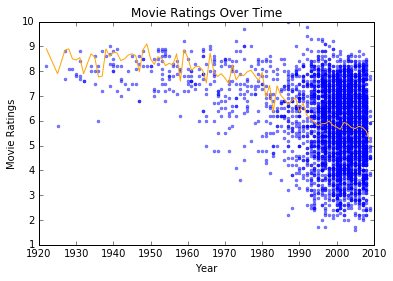

In [98]:
# enter your code here
df = movies[-movies.rtAllCriticsRating.str.contains("N")]
df = df[df.rtTopCriticsRating != "0"]
ratings = pd.to_numeric(df.rtAllCriticsRating)
df = df.drop('rtAllCriticsRating', 1)
df = pd.concat([df,ratings], axis = 1)
temp = pd.DataFrame(df.groupby(df['year']).rtAllCriticsRating.mean()).reset_index()
plt.plot(df['year'], df['rtTopCriticsRating'], '.',color = 'b', alpha=0.5)
plt.plot(temp.year, temp.rtAllCriticsRating, color = 'orange')
plt.xlabel('Year')
plt.ylabel('Movie Ratings')
plt.title('Movie Ratings Over Time')

The average movie rating (the average of rtAllCriticsRating across all movies in a year) has decreased over time. I think it can be due to people's tastes in film have evolved and become more 'picky' since there are so many more movies available now comparing to in 1920s. Also, there are way more data points recently comparing to in the earlier years, which could mean that the reviewers in the earlier years were a biased sample (e.g. movie enthusiastists). 

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [99]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print ("Original text is\n", '\n'.join(text))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print()
print("Transformed text vector is \n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print()
print("Words for each feature:")
print(vectorizer.get_feature_names())


Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [100]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review
w : numpy array (dims: nwords)
    Words for each feature

Examples
--------
X, Y, w = make_xy(reviews)
"""
def make_xy(reviews, vectorizer =None):
    #Your code here
    text = reviews['quote'].tolist()
    if vectorizer == None:
        v = CountVectorizer(min_df = 0)
    else:
        v = vectorizer
    v.fit(text)
    x = v.transform(text)
    X = x.toarray()
    words = v.get_feature_names()
    #Y = np.asarray(reviews['fresh'], dtype="|S6")
    Y = reviews['fresh'].copy().values
    Y = (Y == 'fresh').astype(int)
    #Y[reviews['fresh'] == 'fresh'] = 1
    #Y[reviews['fresh'] == 'rotten'] = 0
        
    return X, Y, words

In [101]:
X, Y, w = make_xy(reviews)

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [102]:
# enter your code here
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.34, random_state=0)

### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [103]:
# enter your code here
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
print('Accuracy of model on training set', clf.score(X_train, y_train, sample_weight=None))
print('Accuracy of model on test set', clf.score(X_test, y_test, sample_weight=None))
# call the fitted model fitted_model, for future reference:
fitted_model = clf.fit(X_train, y_train)# your code here

Accuracy of model on training set 0.92445799458
Accuracy of model on test set 0.778654394039


*enter your observations here*

The accuracy of model on training set (model fit) score is very high: 0.92 whereas the prediction accuracy of model on test set is not as high: 0.779. This implies that my model might be overfited (does not generalize well).

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [104]:
# Your code here

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [105]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# chance the nambes of the variables below to match your code in 2.2 and 2.3
log_likelihood(fitted_model, X_test, y_test)

-2538.6142904817857

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [106]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y, w = make_xy(reviews, vectorizer)
        clf = MultinomialNB(alpha=alpha, class_prior=None, fit_prior=True)
        ll = cross_val_score(clf, X, Y, scoring = log_likelihood).mean()
        
        if ll > max_loglike:
            max_loglike = ll
            best_alpha = alpha
            best_min_df = min_df

In [107]:
print('Best alpha = ', best_alpha)
print('Best min df = ', best_min_df)
print('Maximized log likelihood = ', max_loglike)

Best alpha =  5
Best min df =  0.001
Maximized log likelihood =  -2482.89345479


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [108]:
#Enter your code here
vectorizer = CountVectorizer(min_df = best_min_df)       
X, Y, w = make_xy(reviews, vectorizer)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.34, random_state=0)
clf = MultinomialNB()
MultinomialNB(alpha=best_alpha, class_prior=None, fit_prior=True)
clf.fit(X_train, y_train)
print('Accuracy of model on training set', clf.score(X_train, y_train, sample_weight=None))
print('Accuracy of model on test set', clf.score(X_test, y_test, sample_weight=None))

Accuracy of model on training set 0.804652213189
Accuracy of model on test set 0.759368836292


*enter your observations here*

The model is less accurate (for both training and test set) than the model in 2.3. Training set accuracy: 0.804 versus 0.92, test set accuracy: 0.759 versus 0.779. But the overfitting got better because now the difference between model accuracy on train and test sets is smaller.

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [109]:
#Enter your code here

*enter your observations here*

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [110]:
# Enter your code here
v = CountVectorizer(min_df = 0.001)
X, Y, w = make_xy(reviews, v)

clf = MultinomialNB(alpha=5)
clf.fit(X, Y)
I_matrix = np.identity(len(w))
probs = clf.predict_proba(I_matrix)
p_fresh = probs[:,1]
p_rotten = probs[:,0]

fresh_words = pd.DataFrame({'p_fresh': p_fresh, 'words': w})
rotten_words = pd.DataFrame({'p_rotten': p_rotten, 'words':w})
top_ten_fresh = fresh_words.sort('p_fresh', ascending=False)
top_ten_rotten = rotten_words.sort('p_rotten', ascending=False)
print(top_ten_fresh.head(10))
print(top_ten_rotten.head(10))

       p_fresh          words
1157  0.910841    masterpiece
460   0.906755        delight
1952  0.884859       touching
1538  0.876072     remarkable
1833  0.876072         superb
974   0.872510    intelligent
2132  0.870540          witty
1811  0.869289       stunning
643   0.869289  extraordinary
352   0.868335        complex
      p_rotten           words
2009  0.885493   unfortunately
1047  0.857003            lame
1423  0.852937       pointless
2011  0.834066      uninspired
198   0.828567           bland
501   0.813079  disappointment
531   0.808357            dull
2010  0.807275         unfunny
1590  0.802366           sadly
1937  0.802366        tiresome


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


*enter your observations here*

The words most predictive of freshness are the common positive adjectives used to describe movies, whereas the words most predictive of rotten are the common negative adjectives.

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [111]:
#Your code here
probs = pd.DataFrame(clf.predict_proba(X))
temp = pd.concat([reviews['quote'], reviews['fresh']], axis = 1)
df = pd.concat([probs,temp], axis = 1)
df.columns = ['rotten', 'fresh', 'quote', 'obs']
mis_rotten = df[df.obs=='rotten']
mis_fresh = df[df.obs=='fresh']
mis_fresh.sort(['fresh'], ascending=True, inplace=True)
mis_rotten.sort(['rotten'], ascending=True, inplace=True)


print("Top five mispredicted fresh reviews \n" )
print(mis_rotten.quote[:5].values)
mis_rotten.sort(['fresh'], ascending=False, inplace=True)
print("\n")
print("Top five mispredicted rotten reviews \n" )
print(mis_fresh.quote[:5].values)

review = ["This movie is not remarkable, touching, or superb in any way."]
x = vectorizer.transform(review)
x = x.toarray()
probs = clf.predict_proba(x)
print('\nFreshness probability of "This movie is not remarkable, touching, or superb in any way" : ', probs[:,1])

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:3218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Top five mispredicted fresh reviews 

[ "The film is so proud of its alleged daring that it even begins with a dictionary definition of the word 'deviant.' 'Sitcom' would have been more like it."
 "There are a few narrative twists, but not enough new ideas to keep us guessing. In the end, we're stuck running through air shafts and corridors again."
 "Watching the film is like leafing through a giant sketchbook crammed with intriguing ideas that can't all be comfortably fitted into the same master plan."
 "Pocahontas can't get stirred dramatically for political correctness, the finale will please nobody, and the songs are duff. That said, there are enough incidental felicities to pass the time pleasantly."
 "I wasn't particularly moved or riveted with suspense."]


Top five mispredicted rotten reviews 

[ "Rohmer's impossibly light, graceful way of posing profound moral questions hasn't yet wholly coalesced, though this 1966 film does have his soft, slow rhythm."
 "It's fresh, unexpecte

*Enter your observations here*

These mis-predicted quoates often contain a lot of words belonging to the opposite class, but with a logic in the sentence that reverses the meaning as a whole. Naive Bayes classifiers assume that every word affects the probability independently of other words. This is a bad assumption because the meaning of the sentence is often dependent on the entire sentence (including the logical words) instead of the sum of meanings of each word. For example in "This movie is not remarkable, touching, or superb in any way", the majority of the words are possitive, but with the word 'not', the meaning of the sentence becomes negative. This is not captured if each word is treated independently by Naive Bayes.

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [112]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

RMSE for training set =  6.3133403143103495
RMSE for test set =  7.135932169462302


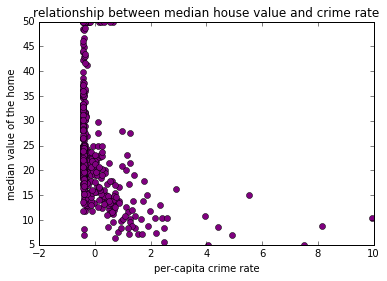

In [113]:
# Enter your code here
features = pd.DataFrame(bdata.data)
house = pd.DataFrame(bdata.target)
house.columns = ['MEDV']

#normalize dataset
scaler = StandardScaler()
scaler.fit(features)                
features = scaler.transform(features)  
features = pd.DataFrame(features)
features.columns = bdata.feature_names

df = pd.concat([features, house], axis=1)
plt.plot(features.CRIM, bdata.target, 'o', color = 'purple')
plt.xlabel('per-capita crime rate')
plt.ylabel('median value of the home')
plt.title('relationship between median house value and crime rate')

from sklearn.linear_model import LinearRegression
train, test = train_test_split(df, test_size=0.34, random_state=200)
lm = smf.ols(formula='MEDV ~ RM', data=train).fit()
pred = lm.predict(train.ix[:, train.columns != 'MEDV'])
print('RMSE for training set = ', sqrt(mean_squared_error(train['MEDV'], pred)))
pred = lm.predict(test.ix[:, test.columns != 'MEDV'])
print('RMSE for test set = ', sqrt(mean_squared_error(test['MEDV'], pred)))

### 4.2 So many scatterplots!

Choose 8 out of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

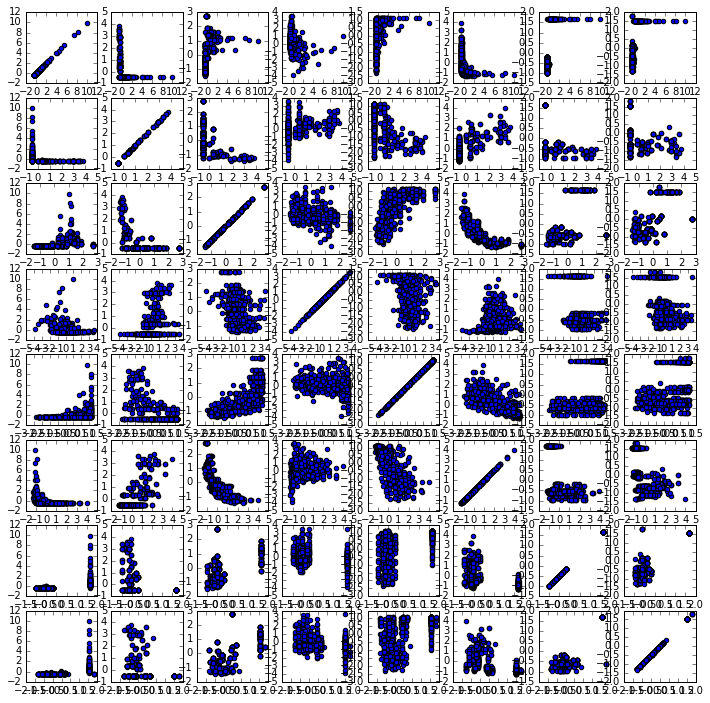

In [114]:
plt.figure(figsize=(12,12))
temp = df.drop(['B','CHAS','PTRATIO','LSTAT','INDUS'], 1)
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, i * 8 + j + 1)
        plt.scatter(temp.iloc[:,i], temp.iloc[:,j])

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

7.52667842418


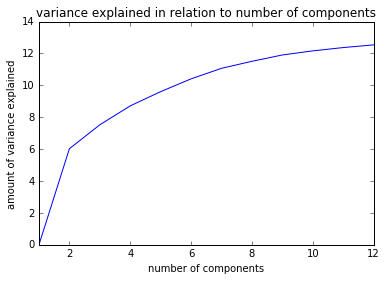

In [115]:
# Enter your code here
pca = PCA(n_components=2)
Xtrain = train.drop('MEDV', 1)
pca.fit(Xtrain)
print(pca.explained_variance_.sum()) 

j = []
v = []
for i in range(12):
    j.append(i+1)
    pca = PCA(n_components=i)
    pca.fit(Xtrain)
    v.append(pca.explained_variance_.sum())

plt.plot(j,v)
plt.xlim(1,12)
plt.xlabel('number of components')
plt.ylabel('amount of variance explained')
plt.title('variance explained in relation to number of components')

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

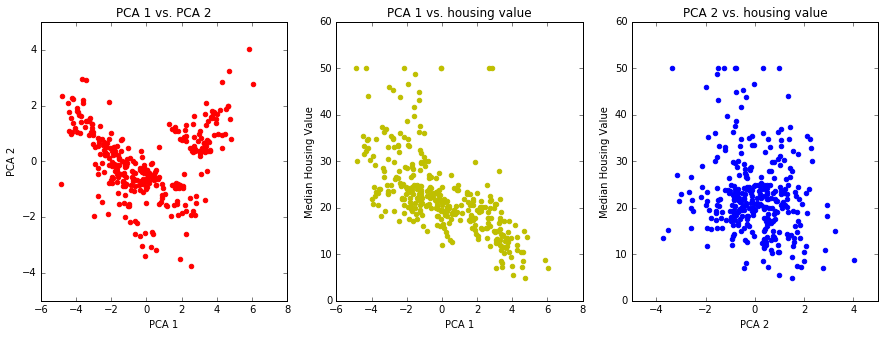

In [116]:
# Enter your code here
pca = PCA(n_components=2)
Xtrain = train.drop('MEDV', 1)
X = pca.fit_transform(Xtrain)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], color = 'r')
plt.title('PCA 1 vs. PCA 2')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], train['MEDV'], color = 'y')
plt.title('PCA 1 vs. housing value')
plt.xlabel('PCA 1')
plt.ylabel('Median Housing Value')
plt.subplot(1, 3, 3)
plt.scatter(X[:, 1], train['MEDV'], color = 'b')
plt.title('PCA 2 vs. housing value')
plt.xlabel('PCA 2')
plt.ylabel('Median Housing Value')

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [117]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, bdata.target, test_size=0.34, random_state=200)
pca = PCA(n_components=1)
Xtrain = pca.fit_transform(Xtrain, X[:, 0])
Xtest = pca.fit_transform(Xtest, X[:, 0])
regr = linear_model.LinearRegression()
regr.fit(Xtrain, train['MEDV'].reshape(333,1))

from sklearn.metrics import mean_squared_error
from math import sqrt

pred = regr.predict(Xtrain)
print('RMSE for training set = ', sqrt(mean_squared_error(ytrain, pred)))
pred = regr.predict(Xtest)
print('RMSE for test set = ', sqrt(mean_squared_error(ytest, pred)))

RMSE for training set =  6.600094610373566
RMSE for test set =  8.394157728994822


The RMSEs of this regression for both the training set and test set are larger than those in 4.1. (training 6.6 vs. 6.31, test 8.39 vs. 7.13) I think it's because although we used the most important component of the dataset of features, there is still some little important data that's biasing the linear regression. Number of rooms seems to be the one feature that has a linear relationship with the house values, whereas the other features' relationships with the outcome remains to be investigated.